### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [3]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-server.ipynb"
%run 00-start-server.ipynb
cursor = connect_to_server()

File '00-start-server.ipynb' already there; not retrieving.

Note: you may need to restart the kernel to use updated packages.


rm: cannot remove 'nohup.out': No such file or directory
Cloning into 'eva'...
cat: nohup.out: No such file or directory
22/09/17 20:47:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
09-17-2022 20:47:02 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF FastRCNNObjectDetector already exists, nothing added.
09-17-2022 20:47:02 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF Array_Count already exists, nothing added.
09-17-2022 20:47:02 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF Crop already exists, nothing added.
09-17-2022 20:47:02 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF DummyObjectDetector already exists, nothing added

### Upload the Video for analysis

In [ ]:
cursor.execute('DROP TABLE MNISTVid')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD FILE "eva/data/mnist/mnist.mp4" INTO MNISTVid')
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                       0
0  Table Successfully dropped: MNISTVid
@batch_size: 1
@identifier_column: None
@query_time: 0.029696430079638958
@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Video successfully added at location: ../data/...
@batch_size: 1
@identifier_column: None
@query_time: 0.02685604291036725


09-11-2022 20:21:36 ERROR [drop_executor:drop_executor.py:exec:0059] Failed to drop TABLE REF:: ( MNISTVid SAMPLE FREQUENCY None)
NoneType: None


### Visualize Video

In [ ]:
from IPython.display import Video
Video("eva/data/mnist/mnist.mp4", embed=True)

### Create an user-defined function (UDF) for analyzing the frames

In [ ]:
cursor.execute("""CREATE UDF IF NOT EXISTS MnistCNN
                  INPUT  (data NDARRAY (3, 28, 28))
                  OUTPUT (label TEXT(2))
                  TYPE  Classification
                  IMPL  'eva/apps/mnist/eva_mnist_udf.py';
        """)
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                              0
0  UDF MnistCNN already exists, nothing added.
@batch_size: 1
@identifier_column: None
@query_time: 0.013792830985039473


09-11-2022 20:21:37 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF MnistCNN already exists, nothing added.


### Run the Image Classification UDF on video

In [ ]:
cursor.execute("""SELECT data, MnistCNN(data).label FROM MNISTVid""")
response = cursor.fetch_all()
print(response.batch)

09-11-2022 20:29:09 WARNING[generic_utils:generic_utils.py:path_to_class:0060] /home/jarulraj3/eva/tutorials/apps/mnist/eva_mnist_udf.py
09-11-2022 20:29:09 WARNING[generic_utils:generic_utils.py:path_to_class:0062] /home/jarulraj3/eva/tutorials/apps/mnist/eva_mnist_udf.py


Batch Object:
@dataframe:                                           mnistvid.data  mnistcnn.label
0     [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...               6
1     [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...               6
2     [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...               6
3     [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...               6
4     [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...               6
...                                                 ...             ...
1195  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...               6
1196  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...               6
1197  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...               6
1198  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...               6
1199  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...               6

[1200 rows x 2 columns]
@batch_size: 1200
@identifier_column: None


### Visualize output of query on the video

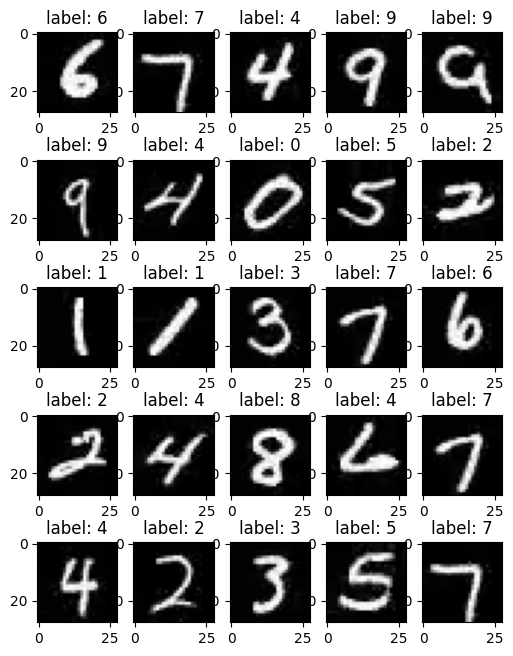

: 

In [ ]:
# !pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=[6,8])

df = response.batch.frames
for axi in ax.flat:
    idx = np.random.randint(len(df))
    img = df['mnistvid.data'].iloc[idx]
    label = df['mnistcnn.label'].iloc[idx]
    axi.imshow(img)
    
    axi.set_title(f'label: {label}')

plt.show()